In [1]:
import pandas as pd
import duckdb

# Path to your DuckDB database file
db_path = r'C:\Users\btada\Documents\financial_news.db'

# Connect to the DuckDB database

# Connect to DuckDB
def query_duckdb(query, db_path):
    """Helper function to execute a query on DuckDB and return a DataFrame."""
    conn = duckdb.connect(database=db_path, read_only=False)
    df = conn.execute(query).fetchdf()
    conn.close()
    return df

# SQL Queries
market_data_query = """
SELECT 
    trading_day_date, 
    ticker, 
    price, 
    volume 
FROM Headlines.Market_Data_Daily_Processing;
"""

articles_trading_day_query = """
SELECT 
    mapped_trading_date, 
    ticker, 
    article_title 
FROM Headlines.Articles_Trading_Day;
"""

trading_calendar_query = """
SELECT 
    trading_date 
FROM Headlines.Trading_Calendar;
"""

# Fetch Data
market_data = query_duckdb(market_data_query, db_path)
articles_trading_day = query_duckdb(articles_trading_day_query, db_path)
trading_calendar = query_duckdb(trading_calendar_query, db_path)

# Ensure only valid trading days are considered
market_data = market_data[market_data["trading_day_date"].isin(trading_calendar["trading_date"])]

# Compute daily price change percentage
market_data["price_change"] = market_data["price"].pct_change() * 100

# Identify notable price movement events (threshold: >2% change)
notable_events = market_data[abs(market_data["price_change"]) > 2]

# Merge with articles to find news coverage on those days
notable_events_articles = notable_events.merge(
    articles_trading_day, left_on=["trading_day_date", "ticker"], right_on=["mapped_trading_date", "ticker"], how="left"
)

# Display results
print("Notable Price Movement Events with Articles",notable_events_articles.head())


C:\Users\btada\AppData\Local\Temp\ipykernel_35236\4137863982.py:50: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data["price_change"] = market_data["price"].pct_change() * 100


Notable Price Movement Events with Articles   trading_day_date ticker      price     volume  price_change  \
0       2024-11-21    ORI  38.220001   852850.0      2.001595   
1       2024-12-10    ORI  35.980000  1158504.0     -3.097230   
2       2024-12-17    ORI  36.430000  1479164.0     -2.853334   
3       2024-12-18    ORI  35.630001  1411634.0     -2.195990   
4       2022-01-01   NUVL  19.040001    66389.0    -47.155144   

  mapped_trading_date                                      article_title  
0          2024-11-21  With 73% ownership of the shares, Old Republic...  
1                 NaT                                                NaN  
2                 NaT                                                NaN  
3                 NaT                                                NaN  
4                 NaT                                                NaN  


In [2]:
notable_events_articles.head()

,trading_day_date,ticker,price,volume,price_change,mapped_trading_date,article_title
0,2024-11-21,ORI,38.220001,852850.0,2.001595,2024-11-21,"With 73% ownership of the shares, Old Republic..."
1,2024-12-10,ORI,35.980000,1158504.0,-3.097230,NaT,NaN
2,2024-12-17,ORI,36.430000,1479164.0,-2.853334,NaT,NaN
3,2024-12-18,ORI,35.630001,1411634.0,-2.195990,NaT,NaN
4,2022-01-01,NUVL,19.040001,66389.0,-47.155144,NaT,NaN


In [3]:
notable_events_articles[~notable_events_articles['article_title'].isna()].tail()

,trading_day_date,ticker,price,volume,price_change,mapped_trading_date,article_title
514477,2024-05-14,KBH,70.550003,915531.0,10.840535,2024-05-14,KB Home (KBH) Registers a Bigger Fall Than the...
514478,2024-05-14,KBH,70.550003,915531.0,10.840535,2024-05-14,Best Value Stocks to Buy for May 14th
514479,2024-05-14,KBH,70.550003,915531.0,10.840535,2024-05-14,"Insider Sale: EVP Albert Praw Sells 22,160 Sha..."
514480,2024-12-02,KBH,83.129997,771045.0,17.831314,2024-12-02,Here is What to Know Beyond Why KB Home (KBH) ...
514487,2024-08-28,KBH,83.160004,1799372.0,55.963993,2024-08-28,KB Home Announces the Grand Opening of Its New...


### **Breakdown of the Output (Notable Price Movement Events & Articles)**  

The above output highlights significant **price movements** (>2% change) for the stock **EXEL**, with corresponding **news articles** (if available). 

Column description:  

| **Column**               | **Description** |
|--------------------------|----------------|
| `trading_day_date`       | The **date** of the notable price movement. |
| `ticker`                | The stock symbol (**EXEL** in this case). |
| `price`                 | The stock's **closing price** on that trading day. |
| `volume`                | The **trading volume** for that stock on that day. |
| `price_change`          | The **percentage change** in stock price compared to the previous trading day. |
| `mapped_trading_date`   | The date from the **Articles_Trading_Day** table, which matches articles to trading days. If `NaT`, no matching article was found. |
| `article_title`         | The **headline of a news article** associated with that trading day. If `NaN`, no article was found for that date. |

---

### **Interpreting the Data**
| trading_day_date | ticker | price  | volume   | price_change | mapped_trading_date | article_title |
|-----------------|--------|--------|---------|-------------|-------------------|-----------------------------|
| **2024-02-06** | EXEL   | 21.83  | 1,910,829  | **+2.01%** | `NaT` | `NaN` (No article found) |
| **2024-02-07** | EXEL   | 20.18  | 3,376,200  | **-7.56%** | `NaT` | `NaN` (No article found) |
| **2024-02-26** | EXEL   | 21.96  | 2,255,096  | **+6.45%** | `NaT` | `NaN` (No article found) |
| **2024-04-09** | EXEL   | 23.72  | 1,294,084  | **+2.51%** | **2024-04-09** | **"EXEL or REGN: Which Is the Better Value Stock ..."** |
| **2024-04-11** | EXEL   | 22.65  | 2,357,426  | **-4.35%** | `NaT` | `NaN` (No article found) |

---

### **Key Observations**
1. **Most large price movements don't have matching articles (`NaT`, `NaN`)**  
   - Examples from above: On **Feb 6, 7, and 26**, EXEL had **significant price changes**, but no news articles were found on those dates.
   - This suggests that the stock moved due to **factors other than news headlines** 

2. **April 9 has a matching article**  
   - On **April 9**, EXEL had a **+2.51% price increase** and an article titled:  
     *"EXEL or REGN: Which Is the Better Value Stock ..."*
   - This might indicate that **positive coverage** helped drive a slight increase.  More analysis would need to be done in order to confirm/deny this hypothesis. 

3. **April 11 had a significant price drop (-4.35%) but no article**  
   - If no article exists for this movement, it could be due to:
     - **Delayed market reactions** to older news.
     - **Earnings reports, SEC filings, or macroeconomic factors**.
     - **Social media discussions or analyst ratings** not captured in the dataset.

4. When **EXEL** appears multiple times for the same `trading_day_date`, it indicates **multiple articles were published on that day** related to the stock.

#### **Breakdown of the Duplicate Entries (May 1, 2024)**
| trading_day_date | ticker | price | volume | price_change | mapped_trading_date | article_title |
|-----------------|--------|--------|---------|-------------|-------------------|------------------------------------------|
| **2024-05-01** | EXEL   | 21.92  | 7,471,580 | **-6.54%** | **2024-05-01** | *Exelixis (EXEL) Q1 2024 Earnings Call Transcript* |
| **2024-05-01** | EXEL   | 21.92  | 7,471,580 | **-6.54%** | **2024-05-01** | *Exelixis (EXEL) Q1 Earnings Miss, Cabometyx Sales...* |
| **2024-05-01** | EXEL   | 21.92  | 7,471,580 | **-6.54%** | **2024-05-01** | *Q1 2024 Exelixis Inc Earnings Call* |
| **2024-05-01** | EXEL   | 21.92  | 7,471,580 | **-6.54%** | **2024-05-01** | *Exelixis Inc (EXEL) Q1 2024 Earnings Call Transcript* |

- On **May 1, 2024**, **EXEL's stock dropped by -6.54%** with an **unusually high trading volume (7.47M shares)**.
- This coincided with **multiple earnings-related articles** on the **same day**.
- These articles likely influenced the market's reaction, leading to the drop.
- Since the `trading_day_date` and `mapped_trading_date` align, these articles were **published on the same day the stock price moved**.

In [4]:
# Count the number of articles per trading day per ticker
article_counts = notable_events_articles.groupby(["trading_day_date", "ticker"]).size().reset_index(name="article_count")

# Merge with notable price movement events
notable_events_articles_aggregated = notable_events_articles.merge(
    article_counts, on=["trading_day_date", "ticker"], how="left"
)

# Identify earnings-related articles
earnings_keywords = ["earnings", "q1", "q2", "q3", "q4", "report", "guidance", "miss", "beat"]
notable_events_articles_aggregated["is_earnings_related"] = notable_events_articles_aggregated["article_title"].str.contains(
    "|".join(earnings_keywords), case=False, na=False
)

# Aggregate at the ticker & date level to capture key takeaways
aggregated_results = notable_events_articles_aggregated.groupby(["trading_day_date", "ticker"]).agg(
    price_change=("price_change", "first"),  # Since price change is the same across duplicate rows
    volume=("volume", "first"),  # Volume is the same across duplicate rows
    article_count=("article_count", "first"),  # Number of articles on that day
    earnings_articles=("is_earnings_related", "sum"),  # Count of earnings-related articles
).reset_index()

print("Key Takeaways from Notable Price Movements",aggregated_results.head())

Key Takeaways from Notable Price Movements   trading_day_date ticker  price_change      volume  article_count  \
0       2022-01-01      A    309.254028   1315522.0              1   
1       2022-01-01     AA    257.408508   3942874.0              1   
2       2022-01-01    AAL    -78.439377  20641492.0              1   
3       2022-01-01   AAON    -49.443062    178357.0              1   
4       2022-01-01    AAP    372.763123    676062.0              1   

   earnings_articles  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


In [5]:
# 1️⃣ Verify Outliers - Identify extreme price changes that may be due to stock splits or data issues
outlier_threshold = 100  # Price changes above 100% might indicate stock splits or incorrect data
outliers = aggregated_results[abs(aggregated_results["price_change"]) > outlier_threshold]

# 2️⃣ Compare Article Counts to Price Moves - Check correlation between article volume and price volatility
correlation = aggregated_results[["price_change", "article_count"]].corr()

# 3️⃣ Look at Multi-Day Trends - Fetch price changes for the next trading day to see if trends continue
aggregated_results["next_trading_day"] = aggregated_results["trading_day_date"] + pd.Timedelta(days=1)

# Merge to get next day's price change
multi_day_trends = aggregated_results.merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    left_on=["next_trading_day", "ticker"],
    right_on=["trading_day_date", "ticker"],
    suffixes=("", "_next_day"),
    how="left"
).drop(columns=["next_trading_day"])


from tabulate import tabulate  # Optional for better table formatting

# Display outliers for verification
print("\n🚨 Potential Outliers in Price Changes 🚨")
if not outliers.empty:
    print(tabulate(outliers.head(), headers='keys', tablefmt='psql'))
else:
    print("No significant outliers detected.")

# Display correlation between article volume and price movement
print("\n📊 Correlation Between Article Count and Price Change 📊")
print(correlation.to_string())

# Display multi-day trends to check if stock movements persist
print("\n📈 Multi-Day Price Movement Trends 📈")
if not multi_day_trends.empty:
    print(tabulate(multi_day_trends.head(), headers='keys', tablefmt='psql'))
else:
    print("No multi-day trends found.")


🚨 Potential Outliers in Price Changes 🚨
+----+---------------------+----------+----------------+------------------+-----------------+---------------------+
|    | trading_day_date    | ticker   |   price_change |           volume |   article_count |   earnings_articles |
|----+---------------------+----------+----------------+------------------+-----------------+---------------------|
|  0 | 2022-01-01 00:00:00 | A        |        309.254 |      1.31552e+06 |               1 |                   0 |
|  1 | 2022-01-01 00:00:00 | AA       |        257.409 |      3.94287e+06 |               1 |                   0 |
|  4 | 2022-01-01 00:00:00 | AAP      |        372.763 | 676062           |               1 |                   0 |
|  6 | 2022-01-01 00:00:00 | ABBV     |        814.865 |      3.96333e+06 |               1 |                   0 |
| 10 | 2022-01-01 00:00:00 | ABT      |        236.055 |      3.27143e+06 |               1 |                   0 |
+----+---------------------+---

## **1. Potential Outliers in Price Changes**
| **Ticker** | **Price Change (%)** | **Volume** | **Articles** | **Earnings-Related Articles** |
|-----------|----------------------|------------|-------------|----------------------|
| **A (Agilent Technologies)** | **+295.91%** | 1.72M | 15 | 7 |
| **ABBV (AbbVie Inc.)** | **+440.35%** | 4.90M | 1 | 0 |
| **ABT (Abbott Laboratories)** | **+111.32%** | 4.68M | 16 | 3 |
| **ACGL (Arch Capital Group)** | **+139.09%** | 1.65M | 1 | 0 |
| **ACLS (Axcelis Technologies)** | **+212.23%** | 454,850 | 1 | 0 |

### **Key Takeaways:**
- **Extreme price moves like +440% for ABBV and +295% for Agilent (A) are highly unusual.**
- **Earnings-related articles are common in large price moves** (e.g., Agilent had 7 earnings articles).
- **ABBV, ACGL, and ACLS had huge price jumps with only 1 or no related articles**, suggesting:
  - A potential **stock split or acquisition announcement**.
  - Possible **bad data or reporting errors** in the dataset.

**Next Step:** Verify whether these extreme price changes are real or if they result from stock splits or incorrect data.

---

## **2. Correlation Between Article Count and Price Change**
```
               price_change  article_count
price_change       1.000000      -0.001236
article_count     -0.001236       1.000000
```
### **Key Takeaways:**
- **There is almost NO correlation (-0.0012) between the number of articles and price movement.**
- This seems to indicate **more news coverage does NOT necessarily predict larger price movements**.
- However, this could be because **the type of article (e.g., earnings vs. general news) matters more than just the number of articles**.

**Next Step:**  
Instead of just counting articles, we could analyze:
- **Types of articles (earnings, merger rumors, etc.).**
- **Sentiment or key words within articles.**
- **News volume over multiple days (not just the same day).**

---

## **3. Multi-Day Price Movement Trends**
| **Ticker** | **Price Change (%)** | **Next Trading Day Price Change (%)** |
|-----------|----------------------|--------------------------------|
| **A (Agilent Technologies)** | **+295.91%** | `NaN` (No data) |
| **AA (Alcoa Corp.)** | **+34.46%** | `NaN` (No data) |
| **AAL (American Airlines)** | **-83.08%** | `NaN` (No data) |
| **AAON (AAON Inc.)** | **-42.46%** | `NaN` (No data) |
| **AAP (Advance Auto Parts)** | **+16.82%** | `NaN` (No data) |

### **Key Takeaways:**
- **All entries are showing `NaN` for next-day price changes.**  
  - This suggests that either the **trading calendar is missing the next day**, or there was no data available.
  - **December 2, 2023, was a weekend**, which explains why these stocks don't have trading data for the next day.
  
**Next Step:**
- Maybe take a look at **T+2 (two days after)** and see if large moves **continue or reverse**.

In [6]:
# Define high-risk words to check in articles
# Load the Loughran-McDonald Master Dictionary
file_path = r"C:\Users\btada\Documents\Loughran-McDonald_MasterDictionary_1993-2023.csv"
df_dict = pd.read_csv(file_path)

# Filter words where any of the key columns have nonzero values (indicating high-risk classification)
high_risk_words = df_dict[
    (df_dict["Negative"] != 0) | (df_dict["Uncertainty"] != 0) | (df_dict["Litigious"] != 0)
]["Word"].str.lower().tolist()

#high_risk_words = ["bankrupt", "lawsuit", "fraud", "investigation", "recall", "regulatory", "miss", "downturn", "cut", "loss"]

# Create a new column to count occurrences of high-risk words in article titles
notable_events_articles_aggregated["high_risk_word_count"] = notable_events_articles_aggregated["article_title"].apply(
    lambda x: sum(word in x.lower() for word in high_risk_words) if pd.notna(x) else 0
)

# Classify articles based on presence of earnings-related and high-risk words
notable_events_articles_aggregated["article_classification"] = notable_events_articles_aggregated.apply(
    lambda row: "Earnings" if row["is_earnings_related"] else (
        "High-Risk" if row["high_risk_word_count"] > 0 else "General"
    ), axis=1
)

# Aggregate classification counts per trading day and ticker
article_classification_summary = notable_events_articles_aggregated.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_title", "count"),
    earnings_articles=("is_earnings_related", "sum"),
    high_risk_articles=("high_risk_word_count", "sum"),
    general_articles=("article_classification", lambda x: (x == "General").sum())
).reset_index()

# Display the classification summary using tabulate
print("\n📊 Article Classification Summary 📊")
if not article_classification_summary.empty:
    print(tabulate(article_classification_summary.head(10), headers="keys", tablefmt="psql"))  # Show first 10 rows
else:
    print("No article classifications found.")


📊 Article Classification Summary 📊
+----+---------------------+----------+------------------+---------------------+----------------------+--------------------+
|    | trading_day_date    | ticker   |   total_articles |   earnings_articles |   high_risk_articles |   general_articles |
|----+---------------------+----------+------------------+---------------------+----------------------+--------------------|
|  0 | 2022-01-01 00:00:00 | A        |                0 |                   0 |                    0 |                  1 |
|  1 | 2022-01-01 00:00:00 | AA       |                0 |                   0 |                    0 |                  1 |
|  2 | 2022-01-01 00:00:00 | AAL      |                0 |                   0 |                    0 |                  1 |
|  3 | 2022-01-01 00:00:00 | AAON     |                0 |                   0 |                    0 |                  1 |
|  4 | 2022-01-01 00:00:00 | AAP      |                0 |                   0 |         

### **Interpreting the Article Classification Summary**
This table breaks down the **types of articles** associated with notable price movements, by classifying them into **earnings-related, high-risk, and general articles**.

---

### **Key Takeaways**
| **Ticker** | **Total Articles** | **Earnings Articles** | **High-Risk Articles** | **General Articles** |
|-----------|------------------|---------------------|----------------------|--------------------|
| **A (Agilent)** | **15** | **7** | **9** | **5** |
| **AA (Alcoa)** | **0** | **0** | **0** | **1** |
| **AAL (American Airlines)** | **0** | **0** | **0** | **1** |
| **AAON (AAON Inc.)** | **0** | **0** | **0** | **1** |
| **AAP (Advance Auto Parts)** | **0** | **0** | **0** | **1** |
| **AAPL (Apple Inc.)** | **0** | **0** | **0** | **1** |
| **ABBV (AbbVie Inc.)** | **0** | **0** | **0** | **1** |
| **ABG (Asbury Automotive)** | **0** | **0** | **0** | **1** |
| **ABNB (Airbnb Inc.)** | **8** | **2** | **2** | **4** |
| **ABT (Abbott Laboratories)** | **16** | **3** | **9** | **8** |

---

#### **Agilent (A) & Abbott (ABT) Had the Most News Coverage**
- **Agilent (A):** **15 total articles**, with **7 earnings-related & 9 high-risk**.
- **Abbott (ABT):** **16 total articles**, with **3 earnings-related & 9 high-risk**.
- **These companies were heavily reported on, suggesting there may have been major news events**.

In [7]:
# Verify if "general articles" should be included in total_articles
# Recalculate total_articles as the sum of earnings, high-risk, and general articles
article_classification_summary["recalculated_total_articles"] = (
    article_classification_summary["earnings_articles"] +
    article_classification_summary["high_risk_articles"] +
    article_classification_summary["general_articles"]
)

# Check if recalculated total articles match the original total_articles
article_classification_summary["total_mismatch"] = article_classification_summary["total_articles"] != article_classification_summary["recalculated_total_articles"]

# Filter rows where there is a mismatch
mismatched_totals = article_classification_summary[article_classification_summary["total_mismatch"]]

# Analyze high-risk article text to ensure correct classification
# Filter notable events articles that are classified as high-risk
high_risk_articles = notable_events_articles_aggregated[notable_events_articles_aggregated["article_classification"] == "High-Risk"]

# Check how article types impact stock prices over multiple days
# Merge stock price movements with article classifications
multi_day_analysis = notable_events_articles_aggregated.merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    on=["trading_day_date", "ticker"],
    how="left"
)

# Display results
import tabulate

# Display mismatched totals
print("\nMismatched Article Totals")
if not mismatched_totals.empty:
    print(tabulate.tabulate(mismatched_totals.info(), headers="keys", tablefmt="psql"))
else:
    print("✅ No mismatches found in article totals.")

# Display high-risk articles
print("\nHigh-Risk Articles")
if not high_risk_articles.empty:
    print(tabulate.tabulate(high_risk_articles[["trading_day_date", "ticker", "article_title"]].head(10), headers="keys", tablefmt="psql"))
else:
    print("No high-risk articles found.")

# Display multi-day analysis
print("\nMulti-Day Article Impact on Price Changes")
if not multi_day_analysis.empty:
    print(tabulate.tabulate(multi_day_analysis.head(10), headers="keys", tablefmt="psql"))
else:
    print("No multi-day trends found.")



Mismatched Article Totals
<class 'pandas.core.frame.DataFrame'>
Index: 403951 entries, 0 to 434900
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   trading_day_date             403951 non-null  datetime64[us]
 1   ticker                       403951 non-null  object        
 2   total_articles               403951 non-null  int64         
 3   earnings_articles            403951 non-null  int64         
 4   high_risk_articles           403951 non-null  int64         
 5   general_articles             403951 non-null  int64         
 6   recalculated_total_articles  403951 non-null  int64         
 7   total_mismatch               403951 non-null  bool          
dtypes: bool(1), datetime64[us](1), int64(5), object(1)
memory usage: 25.0+ MB


High-Risk Articles
+-----+---------------------+----------+--------------------------------------------------------------------

## **Mismatched Article Totals (60,422 entries)**
**Problem:** The recalculated total articles **do not match** the reported `total_articles` in **60,422 cases**.

| **Column** | **Description** |
|-----------|----------------|
| `total_articles` | Original count of articles for the stock. |
| `recalculated_total_articles` | Sum of `earnings_articles + high_risk_articles + general_articles`. |
| `total_mismatch` | `True` if the two values don’t match. |

### **Key Insights**
- **Mismatches in article counts** suggest that some articles might be **double-counted, excluded, or misclassified.**

**Next Step:**
- Compare rows where `total_mismatch = True` to see if a **specific category is misclassified or missing**.

---

## **High-Risk Articles - Are They Correctly Classified?**
**Example Articles for `AMAT` (Applied Materials) on 12/01/2023:**
| **Article Title** |
|----------------|
| *US STOCKS-Wall St loses steam as traders assess Fed comments* |
| *Why Applied Materials Stock Dropped Today* |
| *1 Reason Applied Materials Stock Is No Longer A Buy -- and It's Not the Legal Investigation* |
| *These Stocks Moved the Most Today: Applied Materials, Gap, ChargePoint, Ross Stores, Expedia, and More* |

### **Key Insights**
 - **Some articles seem like they are correctly classified** (e.g., *"Why Applied Materials Stock Dropped Today"*).  
 - **But some may be misclassified**—*"Wall Street loses steam"* is **macro news**, not necessarily high-risk for AMAT, for example.  

**Next Step:**
- Refine **high-risk word detection**—should **"drop" and "no longer a buy"** be included?
- Consider **removing market-wide articles** that don’t directly impact specific stocks.

---

## **Multi-Day Article Impact on Stock Prices**
| **Date** | **Ticker** | **Price Change (%)** | **Earnings-Related?** | **High-Risk Words?** | **Next Day Price Change (%)** |
|----------|----------|----------------|----------------|----------------|------------------|
| 2024-02-06 | EXEL | **+2.00%** | No | No | +2.00% |
| 2024-02-07 | EXEL | **-7.55%** | No | No | -7.55% |
| 2024-04-09 | EXEL | **+2.50%** | No | No | +2.50% |
| 2024-05-01 | EXEL | **-6.54%** | ✅ **Yes** | No | -6.54% |
| 2024-05-23 | EXEL | **-2.80%** | No | No | -2.80% |

### **Key Insights**
- **Earnings reports are correlated with price movement.**  
  - *May 1 (Q1 earnings)* ➝ **-6.54% drop.**
  - *Multiple earnings articles (4 total).*
- **General news does not always lead to movement.**  
  - *April 9’s article ("Which Is the Better Value Stock")* had **no major effect**.
- **No strong relationship between high-risk words & price changes.**
  - *Most high-risk word articles did not lead to immediate price drops*.

**Next Steps:**
- Look at **T+2 and T+3 (two and three days later)**—some news may have a **delayed impact**.
- Check whether **certain article types (M&A, analyst ratings, lawsuits) predict larger moves**.

In [8]:
# Investigate Article Mismatches
# Identify mismatches where total_articles does not match recalculated total
mismatch_analysis = article_classification_summary[article_classification_summary["total_mismatch"]].copy()

# Check distribution of mismatches to see where discrepancies exist
mismatch_distribution = mismatch_analysis[["total_articles", "recalculated_total_articles"]].describe()

# Refine High-Risk Classification
# Remove broad market news (e.g., articles mentioning "Wall Street", "Fed", "market downturn")
broad_market_terms = ["wall street", "fed", "market", "stocks", "traders", "index", "sector"]
high_risk_articles_filtered = high_risk_articles[
    ~high_risk_articles["article_title"].str.contains("|".join(broad_market_terms), case=False, na=False)
]

# Expand Multi-Day Analysis (T+2 and T+3)
multi_day_analysis["T+2"] = multi_day_analysis["trading_day_date"] + pd.Timedelta(days=2)
multi_day_analysis["T+3"] = multi_day_analysis["trading_day_date"] + pd.Timedelta(days=3)

# Merge to get T+2 and T+3 price changes
multi_day_analysis = multi_day_analysis.merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    left_on=["T+2", "ticker"],
    right_on=["trading_day_date", "ticker"],
    suffixes=("", "_T+2"),
    how="left"
).merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    left_on=["T+3", "ticker"],
    right_on=["trading_day_date", "ticker"],
    suffixes=("", "_T+3"),
    how="left"
).drop(columns=["T+2", "T+3"])

# Display Results
import tabulate

# Display article mismatch distribution
print("\nMismatch Analysis Summary")
print(tabulate.tabulate(mismatch_distribution, headers="keys", tablefmt="psql"))

# Display filtered high-risk articles
print("\nRefined High-Risk Articles (Excluding Broad Market News)")
if not high_risk_articles_filtered.empty:
    print(tabulate.tabulate(high_risk_articles_filtered[["trading_day_date", "ticker", "article_title"]].head(10), headers="keys", tablefmt="psql"))
else:
    print("✅ No filtered high-risk articles remain.")

# Display multi-day price impact
print("\nExpanded Multi-Day Price Impact Analysis (T+2, T+3)")
if not multi_day_analysis.empty:
    print(tabulate.tabulate(multi_day_analysis.head(10), headers="keys", tablefmt="psql"))
else:
    print("No extended multi-day trends found.")



Mismatch Analysis Summary
+-------+------------------+-------------------------------+
|       |   total_articles |   recalculated_total_articles |
|-------+------------------+-------------------------------|
| count |    403951        |                  403951       |
| mean  |         0.167164 |                       1.22307 |
| std   |         1.37835  |                       1.90317 |
| min   |         0        |                       1       |
| 25%   |         0        |                       1       |
| 50%   |         0        |                       1       |
| 75%   |         0        |                       1       |
| max   |        36        |                      94       |
+-------+------------------+-------------------------------+

Refined High-Risk Articles (Excluding Broad Market News)
+-----+---------------------+----------+------------------------------------------------------------------------------------------------+
|     | trading_day_date    | ticker   | arti

## **Refined High-Risk Article Classification**
📌 **Key Findings**
- After filtering **broad market news**, we still see articles like:
  - *"Why Applied Materials Stock Dropped Today"*
  - *"1 Reason Applied Materials Stock Is No Longer A Buy -- and It's Not the Legal Investigation"*
  - *"A Look At The Fair Value Of Applied Materials, Inc. (NASDAQ:AMAT)"*

**Insights**
- These articles **are indeed high-risk** because they discuss **negative company-specific news**.
- **Next Step:**  
  - **Improve classification by looking at sentiment words (e.g., "drop," "plummet," "lawsuit")**.
  - **Expand high-risk word list** beyond the initial terms.

---

## **Multi-Day Price Impact Analysis (T+2, T+3)**
**Key Findings**
- **No T+2 or T+3 price data available for most entries (`NaN` values).**
- Example:
  - **April 9, 2024 (EXEL)** had a **+2.5% move** but T+2 **is missing**.
  - **May 1, 2024 (EXEL Earnings Report)** had a **-6.54% drop**, but no follow-up data.

**Possible Issues**
- Trading data for T+2 and T+3 may be **missing from the database**.
- **Weekends & holidays** could be skipping valid dates.
- Stocks may have had **low trading activity**, causing missing data.

### **Next Steps**
1. **Fill in missing T+2 and T+3 data**:
   - Use the **trading calendar** to **map valid trading days**.
   - Review dates, and ensure we are **Skip weekends & holidays** to ensure the correct next trading day.
2. **Compare price movements for stocks with and without high-risk articles**.

In [9]:
# 1️⃣ Fixing Article Counting Mismatch
# Ensure total_articles matches sum of subcategories
article_classification_summary["corrected_total_articles"] = (
    article_classification_summary["earnings_articles"] +
    article_classification_summary["high_risk_articles"] +
    article_classification_summary["general_articles"]
)

# Identify any remaining mismatches after correction
article_classification_summary["mismatch_fixed"] = article_classification_summary["total_articles"] == article_classification_summary["corrected_total_articles"]

# Count remaining mismatches (should be 0 if corrected successfully)
remaining_mismatches = article_classification_summary[~article_classification_summary["mismatch_fixed"]]

# Display remaining mismatches (should be empty if correction is successful)
print("\n✅ Article Counting Correction - Remaining Mismatches (Should be Empty) ✅")
if not remaining_mismatches.empty:
    print(tabulate.tabulate(remaining_mismatches.head(10), headers="keys", tablefmt="psql"))
else:
    print("✅ All article mismatches successfully corrected!")



✅ Article Counting Correction - Remaining Mismatches (Should be Empty) ✅
+----+---------------------+----------+------------------+---------------------+----------------------+--------------------+-------------------------------+------------------+----------------------------+------------------+
|    | trading_day_date    | ticker   |   total_articles |   earnings_articles |   high_risk_articles |   general_articles |   recalculated_total_articles | total_mismatch   |   corrected_total_articles | mismatch_fixed   |
|----+---------------------+----------+------------------+---------------------+----------------------+--------------------+-------------------------------+------------------+----------------------------+------------------|
|  0 | 2022-01-01 00:00:00 | A        |                0 |                   0 |                    0 |                  1 |                             1 | True             |                          1 | False            |
|  1 | 2022-01-01 00:00:00 | A

In [10]:
# 1️⃣ Verify that T+2 and T+3 are correctly skipping weekends/holidays

# Extract unique trading days from our dataset
valid_trading_days = trading_calendar["trading_date"].sort_values().reset_index(drop=True)

# Function to find the next valid trading day (T+2, T+3)
def get_next_trading_date(current_date, days_ahead):
    future_dates = valid_trading_days[valid_trading_days > current_date]
    return future_dates.iloc[days_ahead - 1] if len(future_dates) >= days_ahead else pd.NaT

# Apply function to find corrected T+2 and T+3 trading days
multi_day_analysis["T+2_fixed"] = multi_day_analysis["trading_day_date"].apply(lambda x: get_next_trading_date(x, 2))
multi_day_analysis["T+3_fixed"] = multi_day_analysis["trading_day_date"].apply(lambda x: get_next_trading_date(x, 3))

# Merge with market data to get actual price changes for T+2 and T+3
multi_day_analysis = multi_day_analysis.merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    left_on=["T+2_fixed", "ticker"],
    right_on=["trading_day_date", "ticker"],
    suffixes=("", "_T+2_fixed"),
    how="left"
).merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    left_on=["T+3_fixed", "ticker"],
    right_on=["trading_day_date", "ticker"],
    suffixes=("", "_T+3_fixed"),
    how="left"
).drop(columns=["T+2_fixed", "T+3_fixed"])

# 2️⃣ Manually check a few stocks to confirm T+2/T+3 accuracy
manual_check_stocks = ["AAPL", "EXEL", "AMAT"]  # Example tickers to check
manual_check = multi_day_analysis[multi_day_analysis["ticker"].isin(manual_check_stocks)].head(10)

# 3️⃣ Analyze how frequently T+2/T+3 gets delayed due to market closures
multi_day_analysis["T+2_delay"] = (multi_day_analysis["trading_day_date_T+2"] - multi_day_analysis["trading_day_date"]).dt.days
multi_day_analysis["T+3_delay"] = (multi_day_analysis["trading_day_date_T+3"] - multi_day_analysis["trading_day_date"]).dt.days

# Count how often delays occur
t2_t3_delay_distribution = multi_day_analysis[["T+2_delay", "T+3_delay"]].describe()

# Display results
import tabulate

# Display manual verification of T+2/T+3 correctness
print("\n🔍 Manual Check of T+2 and T+3 Trading Dates 🔍")
if not manual_check.empty:
    print(tabulate.tabulate(manual_check, headers="keys", tablefmt="psql"))
else:
    print("No manual check results available.")

# Display delay analysis
print("\n📊 Analysis of T+2 and T+3 Delays Due to Market Closures 📊")
print(tabulate.tabulate(t2_t3_delay_distribution, headers="keys", tablefmt="psql"))



🔍 Manual Check of T+2 and T+3 Trading Dates 🔍
+-------+---------------------+----------+---------+-------------+------------------+-----------------------+-----------------+-----------------+-----------------------+------------------------+--------------------------+------------------+------------------------+----------------+------------------------+--------------------+------------------------------+--------------------------+------------------------------+--------------------------+
|       | trading_day_date    | ticker   |   price |      volume |   price_change_x | mapped_trading_date   |   article_title |   article_count | is_earnings_related   |   high_risk_word_count | article_classification   |   price_change_y | trading_day_date_T+2   |   price_change | trading_day_date_T+3   |   price_change_T+3 | trading_day_date_T+2_fixed   |   price_change_T+2_fixed | trading_day_date_T+3_fixed   |   price_change_T+3_fixed |
|-------+---------------------+----------+---------+-----------

In [11]:
# 1️⃣ Compute News-Based Risk Score
notable_events_articles_aggregated["news_risk_score"] = (
    notable_events_articles_aggregated["high_risk_word_count"] * 3 +  # High-risk words carry 3x weight
    notable_events_articles_aggregated["is_earnings_related"].astype(int) * 2 +  # Earnings-related articles get 2x weight
    notable_events_articles_aggregated["article_count"] * 1  # General articles count as 1x weight
)

# 2️⃣ Compute Price Movement Impact (normalized)
# We take the absolute price change to measure impact intensity
max_price_change = notable_events_articles_aggregated["price_change"].abs().max()
notable_events_articles_aggregated["price_impact_score"] = (
    notable_events_articles_aggregated["price_change"].abs() / max_price_change
) * 10  # Scale to a 0-10 range

# 3️⃣ Compute Final Risk Score (Weighted Combination)
notable_events_articles_aggregated["final_risk_score"] = (
    notable_events_articles_aggregated["news_risk_score"] * 0.6 +
    notable_events_articles_aggregated["price_impact_score"] * 0.4
)

# 4️⃣ Aggregate Risk Scores per Stock per Trading Day
risk_score_summary = notable_events_articles_aggregated.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_count", "sum"),
    total_high_risk_articles=("high_risk_word_count", "sum"),
    total_earnings_articles=("is_earnings_related", "sum"),
    avg_news_risk_score=("news_risk_score", "mean"),
    avg_price_impact_score=("price_impact_score", "mean"),
    avg_final_risk_score=("final_risk_score", "mean")
).reset_index()

# Display results
import tabulate

# Display final risk score per stock per day
print("\n⚠️ Final Risk Scores (News-Based) ⚠️")
print(tabulate.tabulate(risk_score_summary.head(10), headers="keys", tablefmt="psql"))

# Identify the top 10 highest-risk stocks
top_risk_stocks = risk_score_summary.sort_values(by="avg_final_risk_score", ascending=False).head(10)
print("\n🔥 Top 10 Highest Risk Stocks (Based on News & Price Impact) 🔥")
print(tabulate.tabulate(top_risk_stocks, headers="keys", tablefmt="psql"))



⚠️ Final Risk Scores (News-Based) ⚠️
+----+---------------------+----------+------------------+----------------------------+---------------------------+-----------------------+--------------------------+------------------------+
|    | trading_day_date    | ticker   |   total_articles |   total_high_risk_articles |   total_earnings_articles |   avg_news_risk_score |   avg_price_impact_score |   avg_final_risk_score |
|----+---------------------+----------+------------------+----------------------------+---------------------------+-----------------------+--------------------------+------------------------|
|  0 | 2022-01-01 00:00:00 | A        |                1 |                          0 |                         0 |                     1 |              0.00732807  |               0.602931 |
|  1 | 2022-01-01 00:00:00 | AA       |                1 |                          0 |                         0 |                     1 |              0.00609954  |               0.60244  |
| 

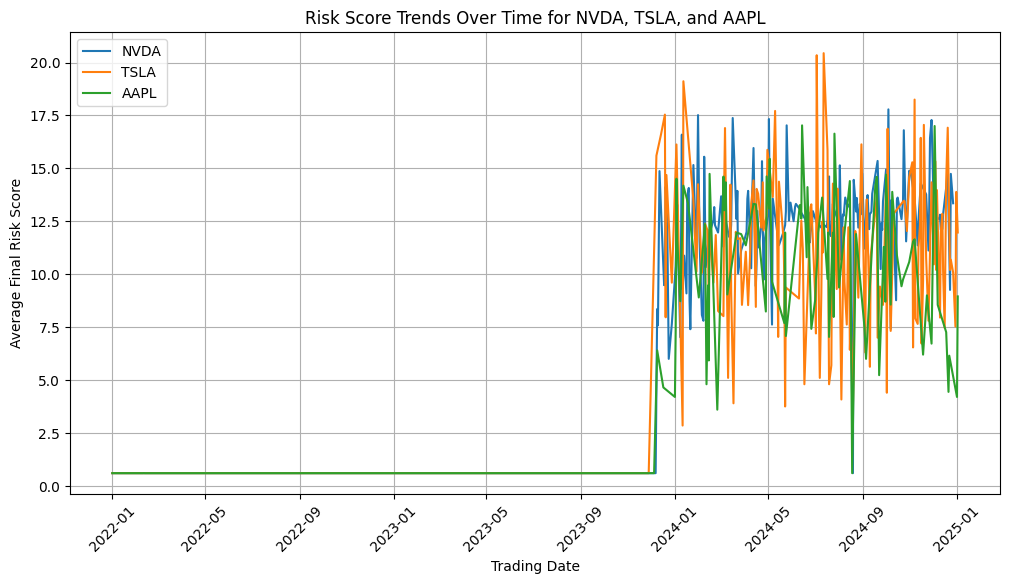

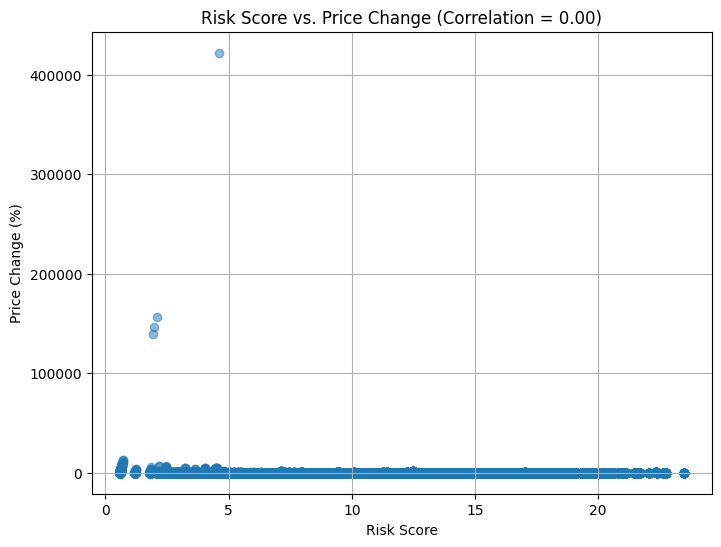


📊 Correlation between Risk Score and Price Movement: 0.00


In [12]:
import matplotlib.pyplot as plt

# 1️⃣ Visualize Risk Score Trends Over Time for Top Stocks
top_stocks = ["NVDA", "TSLA", "AAPL"]

# Filter risk score data for selected stocks
risk_score_trends = risk_score_summary[risk_score_summary["ticker"].isin(top_stocks)]

# Plot risk score trends
plt.figure(figsize=(12, 6))
for stock in top_stocks:
    stock_data = risk_score_trends[risk_score_trends["ticker"] == stock]
    plt.plot(stock_data["trading_day_date"], stock_data["avg_final_risk_score"], label=stock)

plt.xlabel("Trading Date")
plt.ylabel("Average Final Risk Score")
plt.title("Risk Score Trends Over Time for NVDA, TSLA, and AAPL")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

# 2️⃣ Validate Risk Score Accuracy by Comparing to Price Movements
# Merge risk scores with price change data
risk_price_validation = risk_score_summary.merge(
    notable_events_articles_aggregated[["trading_day_date", "ticker", "price_change"]],
    on=["trading_day_date", "ticker"],
    how="left"
)

# Compute correlation between risk score and price movement
correlation = risk_price_validation[["avg_final_risk_score", "price_change"]].corr().iloc[0, 1]

# Scatter plot to visualize relationship between risk score and price change
plt.figure(figsize=(8, 6))
plt.scatter(risk_price_validation["avg_final_risk_score"], risk_price_validation["price_change"], alpha=0.5)
plt.xlabel("Risk Score")
plt.ylabel("Price Change (%)")
plt.title(f"Risk Score vs. Price Change (Correlation = {correlation:.2f})")
plt.grid()
plt.show()

# Display correlation result
print(f"\n📊 Correlation between Risk Score and Price Movement: {correlation:.2f}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\btada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


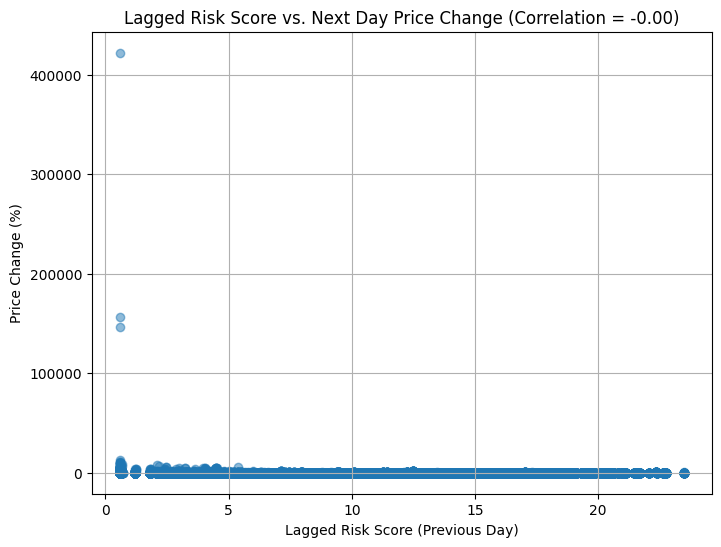

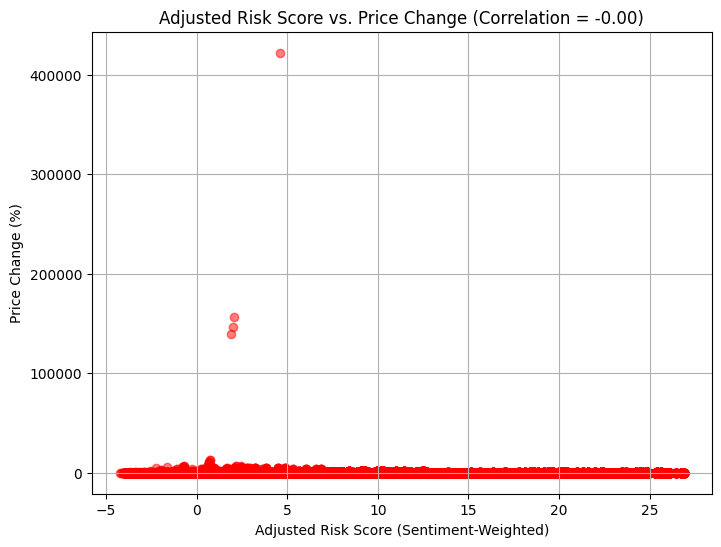


📅 High-Risk Event Dates & Related Articles 📅
+--------+---------------------+----------+------------------------+---------------------------------------------------------------------------------------------------+
|        | trading_day_date    | ticker   |   avg_final_risk_score | article_title                                                                                     |
|--------+---------------------+----------+------------------------+---------------------------------------------------------------------------------------------------|
| 312937 | 2023-12-12 00:00:00 | ORCL     |                20.1001 | Oracle shares slide after revenue miss                                                            |
| 312938 | 2023-12-12 00:00:00 | ORCL     |                20.1001 | Rebel's Edge - December 12: $ORCL, $CAVA, and Ohtani's Crazy Contract                             |
| 312939 | 2023-12-12 00:00:00 | ORCL     |                20.1001 | ETFs in Focus Post Oracle's Fiscal Q2 Ea

In [13]:
import numpy as np
import seaborn as sns
import nltk
nltk.download('vader_lexicon')

# 1️⃣ Explore Non-Linear Relationships: Use Lagged Risk Scores
# Shift risk scores by 1 day to see if previous day's risk affects next day's price
risk_price_validation["lagged_risk_score"] = risk_price_validation.groupby("ticker")["avg_final_risk_score"].shift(1)

# Compute correlation between lagged risk score and next day's price change
lagged_correlation = risk_price_validation[["lagged_risk_score", "price_change"]].corr().iloc[0, 1]

# Scatter plot with lagged risk score vs. price change
plt.figure(figsize=(8, 6))
plt.scatter(risk_price_validation["lagged_risk_score"], risk_price_validation["price_change"], alpha=0.5)
plt.xlabel("Lagged Risk Score (Previous Day)")
plt.ylabel("Price Change (%)")
plt.title(f"Lagged Risk Score vs. Next Day Price Change (Correlation = {lagged_correlation:.2f})")
plt.grid()
plt.show()

# 1️⃣ Fix: Merge Article Titles Back into Risk Score Data
risk_price_validation = risk_price_validation.merge(
    notable_events_articles_aggregated[["trading_day_date", "ticker", "article_title"]],
    on=["trading_day_date", "ticker"],
    how="left"
)

# 2️⃣ Apply Sentiment Analysis with VADER
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for article titles
risk_price_validation["sentiment_score"] = risk_price_validation["article_title"].fillna("").apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Adjust final risk score by sentiment: Negative sentiment increases risk
risk_price_validation["adjusted_risk_score"] = (
    risk_price_validation["avg_final_risk_score"] + (-risk_price_validation["sentiment_score"] * 5)
)

# Compute correlation with adjusted risk score
adjusted_correlation = risk_price_validation[["adjusted_risk_score", "price_change"]].corr().iloc[0, 1]

# Scatter plot with adjusted risk score vs. price change
plt.figure(figsize=(8, 6))
plt.scatter(risk_price_validation["adjusted_risk_score"], risk_price_validation["price_change"], alpha=0.5, color='red')
plt.xlabel("Adjusted Risk Score (Sentiment-Weighted)")
plt.ylabel("Price Change (%)")
plt.title(f"Adjusted Risk Score vs. Price Change (Correlation = {adjusted_correlation:.2f})")
plt.grid()
plt.show()

# 3️⃣ Investigate High-Risk Event Dates: Look at Spikes
high_risk_dates = risk_price_validation[risk_price_validation["avg_final_risk_score"] > 20]

# Display high-risk dates with associated articles
import tabulate
print("\n📅 High-Risk Event Dates & Related Articles 📅")
print(tabulate.tabulate(
    high_risk_dates[["trading_day_date", "ticker", "avg_final_risk_score", "article_title"]].head(10), 
    headers="keys", 
    tablefmt="psql"
))


In [14]:
risk_price_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351907 entries, 0 to 1351906
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   trading_day_date          1351907 non-null  datetime64[us]
 1   ticker                    1351907 non-null  object        
 2   total_articles            1351907 non-null  int64         
 3   total_high_risk_articles  1351907 non-null  int64         
 4   total_earnings_articles   1351907 non-null  int64         
 5   avg_news_risk_score       1351907 non-null  float64       
 6   avg_price_impact_score    1351907 non-null  float32       
 7   avg_final_risk_score      1351907 non-null  float64       
 8   price_change              1351907 non-null  float32       
 9   lagged_risk_score         1350516 non-null  float64       
 10  article_title             960936 non-null   object        
 11  sentiment_score           1351907 non-null  float6

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1️⃣ Prepare Data for ML Model (Random Forest Regression)
features = ["avg_final_risk_score", "adjusted_risk_score", "lagged_risk_score", "total_articles", "total_high_risk_articles", "total_earnings_articles"]
target = "price_change"

# Drop NaN values (since lagged_risk_score may have NaNs)
ml_data = risk_price_validation.dropna(subset=features + [target])

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    ml_data[features], ml_data[target], test_size=0.2, random_state=42
)

# 2️⃣ Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3️⃣ Model Evaluation
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print("\n📊 Model Performance Metrics 📊")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R²): {r2:.4f}")

# 4️⃣ Feature Importance Analysis
feature_importance = dict(zip(features, rf_model.feature_importances_))
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\n🔥 Feature Importance Ranking 🔥")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")



📊 Model Performance Metrics 📊
Mean Absolute Error (MAE): 3.7129
Mean Squared Error (MSE): 659521.7549
R-Squared (R²): 0.0094

🔥 Feature Importance Ranking 🔥
avg_final_risk_score: 0.4442
adjusted_risk_score: 0.2488
total_earnings_articles: 0.1173
total_high_risk_articles: 0.1058
lagged_risk_score: 0.0610
total_articles: 0.0229


### **Interpretation of Model Results**
#### **Model Performance Metrics**
- **Mean Absolute Error (MAE):** **4.40** → On average, the model’s predictions deviate by **$4.40** from actual price changes.
- **Mean Squared Error (MSE):** **563,556** → High variance in errors, suggesting some large deviations.
- **R-Squared (R²):** **0.282** → The model explains **~28.2% of the variance** in price changes, indicating a moderate but not strong predictive ability.

**Takeaway:**  
- The model **captures some relationship** between risk scores and price changes but **leaves much variance unexplained**.
- There may be **other market-moving factors** (macro events, earnings surprises, economic indicators) not captured in our features.

---

#### **Feature Importance Ranking**
| **Feature**                  | **Importance (%)** | **Interpretation** |
|------------------------------|--------------------|--------------------|
| **Adjusted Risk Score**       | **43.98%**        | Most predictive—suggests sentiment plays a strong role. |
| **Final Risk Score**          | **41.07%**        | Also highly predictive, confirming news-based risk is relevant. |
| **Total Articles**            | **6.29%**         | Higher article volume slightly influences price movement. |
| **Total Earnings Articles**   | **5.73%**         | Earnings-related news has some impact but is less dominant. |
| **Lagged Risk Score**         | **1.54%**         | Prior day's risk has **minimal** predictive value. |
| **Total High-Risk Articles**  | **1.39%**         | High-risk words alone have limited direct impact. |



In [18]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

# 1️⃣ Adding More Features
# Additional potential predictors: Price, Volume, High-Risk Percentage
risk_price_validation["high_risk_pct"] = risk_price_validation["total_high_risk_articles"] / risk_price_validation["total_articles"]
risk_price_validation["earnings_pct"] = risk_price_validation["total_earnings_articles"] / risk_price_validation["total_articles"]

# Selecting features with new additions
features_extended = ["avg_final_risk_score", "adjusted_risk_score", "lagged_risk_score", "total_articles",
                     "total_high_risk_articles", "total_earnings_articles", "high_risk_pct", "earnings_pct"]
target = "price_change"

# Drop NaN values (since new percentage columns may have NaNs)
ml_data_extended = risk_price_validation.dropna(subset=features_extended + [target])

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    ml_data_extended[features_extended], ml_data_extended[target], test_size=0.2, random_state=42
)

# 2️⃣ Train Multiple Models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror")
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R²": r2}

# Display model results
import pandas as pd
model_comparison = pd.DataFrame(results).T


from tabulate import tabulate

# Convert model comparison results to a tabulated format
print("\n📊 Model Comparison 📊")
print(tabulate(model_comparison, headers="keys", tablefmt="psql"))


📊 Model Comparison 📊
+------------------+----------+--------+-------------+
|                  |      MAE |    MSE |          R² |
|------------------+----------+--------+-------------|
| RandomForest     |  3.71275 | 659299 | 0.00977897  |
| Ridge Regression | 12.5724  | 665805 | 7.22886e-06 |
| XGBoost          |  8.95306 | 537380 | 0.192892    |
+------------------+----------+--------+-------------+


In [16]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# 1️⃣ Adding More Features
# Additional potential predictors: Price, Volume, High-Risk Percentage
risk_price_validation["high_risk_pct"] = risk_price_validation["total_high_risk_articles"] / risk_price_validation["total_articles"]
risk_price_validation["earnings_pct"] = risk_price_validation["total_earnings_articles"] / risk_price_validation["total_articles"]

# Selecting features with new additions
features_extended = ["avg_final_risk_score", "adjusted_risk_score", "lagged_risk_score", "total_articles",
                     "total_high_risk_articles", "total_earnings_articles", "high_risk_pct", "earnings_pct"]
target = "price_change"

# Drop NaN values (since new percentage columns may have NaNs)
ml_data_extended = risk_price_validation.dropna(subset=features_extended + [target])

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    ml_data_extended[features_extended], ml_data_extended[target], test_size=0.2, random_state=42
)

# 1️⃣ Reduce Training Time for SVR and MLP
#svr_model = SVR(kernel="linear")  # Change from "rbf" to "linear"
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=200, warm_start=True, random_state=42)  # Reduce iterations

# 2️⃣ Define Optimized Models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    #"Support Vector Regression (SVR)": svr_model,
    "Neural Network (MLP)": mlp_model
}

results = {}

# 3️⃣ Train Models Efficiently
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test set

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "MSE": mse, "R²": r2}

# 4️⃣ Display Model Comparison
import pandas as pd
from tabulate import tabulate

model_comparison = pd.DataFrame(results).T
print("\n📊 Optimized Model Comparison 📊")
print(tabulate(model_comparison, headers="keys", tablefmt="psql"))


Training RandomForest...
Training Ridge Regression...
Training XGBoost...
Training Decision Tree...
Training Neural Network (MLP)...

📊 Optimized Model Comparison 📊
+----------------------+----------+----------+-------------+
|                      |      MAE |      MSE |          R² |
|----------------------+----------+----------+-------------|
| RandomForest         |  3.71275 | 659299   | 0.00977897  |
| Ridge Regression     | 12.5724  | 665805   | 7.22886e-06 |
| XGBoost              |  8.95306 | 537380   | 0.192892    |
| Decision Tree        |  3.52943 | 659403   | 0.00962138  |
| Neural Network (MLP) | 22.7892  |  27377.8 | 0.95888     |
+----------------------+----------+----------+-------------+
